In [ ]:
!pip install -q matplotlib
!pip install -q pandas 

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, countDistinct, isnan, when
import pyspark.sql.types as t 
from pyspark.sql.functions import desc
from pyspark.sql import functions as F

from functools import reduce
import operator

In [2]:
def get_counts_and_distinct_values(df, col_name):
    count_df = df.groupBy(col_name).count()
    distinct_df = df.select(col_name).distinct().orderBy(F.col(col_name).desc())
    result_df = count_df.join(distinct_df, on=col_name, how="inner")
    return result_df


def filter_df_by_column_values(df, col_name, values, invert_filter=False):
    if invert_filter:
        condition = ~F.col(col_name).isin(values)
    else:
        condition = F.col(col_name).isin(values)
    
    return df.filter(condition)

def count_nulls_percentage(df, col_name):
    return df.groupBy("titleType").agg(
        F.count(F.when(F.col(col_name).isNull() | (F.col(col_name) == "\\N"), 1)).alias(f"{col_name}_null"),
        F.count("*").alias("total_count")
    ).withColumn(
        f"{col_name}_percent",
        F.round((F.col(f"{col_name}_null") / F.col("total_count")) * 100, 2)
    )
    

In [3]:
spark = SparkSession.builder.getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/03 08:30:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### **title.basics.tsv**

|      Name      |    Type      |   Description   |
| -------------  | ------------ | ----------------|
| tconst         | string       | alphanumeric unique identifier of the title |
| titleType      | string       | the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc) |
| primaryTitle   | string       | the more popular title / the title used by the filmmakers on promotional materials at the point of release |
| originalTitle  | string       | original title, in the original language |
| isAdult        | boolean      | 0: non-adult title; 1: adult title |
| startYear      | YYYY         | represents the release year of a title. In the case of TV Series, it is the series start year |
| endYear        | YYYY         | TV Series end year. ‘\N’ for all other title types |
| runtimeMinutes | integer      | primary runtime of the title, in minutes |
| genres         | string array | includes up to three genres associated with the title |

In [4]:
title_basics_schema = t.StructType([
    t.StructField('tconst', t.StringType(), True),
    t.StructField('titleType', t.StringType(), True),
    t.StructField('primaryTitle', t.StringType(), True),
    t.StructField('originalTitle', t.StringType(), True),
    t.StructField('isAdult', t.IntegerType(), True),
    t.StructField('startYear', t.DateType(), True),
    t.StructField('endYear', t.DateType(), True),
    t.StructField('runtimeMinutes', t.IntegerType(), True),
    t.StructField('genres', t.StringType(), True),
])

In [5]:
df = spark.read.csv(f'../data/title.basics.tsv', 
                    sep=r'\t', 
                    header=True,
                    schema=title_basics_schema,
                    inferSchema=False)
df.show()

+---------+---------+--------------------+--------------------+-------+----------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult| startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+----------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|1894-01-01|   null|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|1892-01-01|   null|             5|     Animation,Short|
|tt0000003|    short|        Poor Pierrot|      Pauvre Pierrot|      0|1892-01-01|   null|             5|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|1892-01-01|   null|            12|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|1893-01-01|   null|             1|      

In [6]:
row_count = df.count()
print(f"Total Rows: {row_count}")

[Stage 1:=============================>                             (4 + 4) / 8]

Total Rows: 11530944


In [15]:
counts = df.select([
    (
        F.count(F.when(F.isnan(c) | F.col(c).isNull(), 1))  
        if t in ("float", "double")  
        else F.count(F.when(F.col(c).isNull() | (F.col(c) == "\\N"), 1))
    ).alias(c)
    for c, t in df.dtypes
])

print("NaN Counts per Column:")
counts.show()

NaN Counts per Column:


[Stage 10:===========================================>              (6 + 2) / 8]

+------+---------+------------+-------------+-------+---------+--------+--------------+------+
|tconst|titleType|primaryTitle|originalTitle|isAdult|startYear| endYear|runtimeMinutes|genres|
+------+---------+------------+-------------+-------+---------+--------+--------------+------+
|     0|        0|           0|            0|      0|  1424635|11392503|       7851559|507973|
+------+---------+------------+-------------+-------+---------+--------+--------------+------+



In [9]:
unique_counts = df.select([countDistinct(c).alias(c) for c in df.columns])
print("Unique Values per Column:")
unique_counts.show()

Unique Values per Column:


[Stage 15:===================================================>      (8 + 1) / 9]

+--------+---------+------------+-------------+-------+---------+-------+--------------+------+
|  tconst|titleType|primaryTitle|originalTitle|isAdult|startYear|endYear|runtimeMinutes|genres|
+--------+---------+------------+-------------+-------+---------+-------+--------------+------+
|11530944|       11|     5184830|      5209859|     44|      151|     95|           939|  2385|
+--------+---------+------------+-------------+-------+---------+-------+--------------+------+



## isAdult column

In [12]:
distinct_isAdult = get_counts_and_distinct_values(df, "isAdult")
distinct_isAdult.show()

+-------+--------+
|isAdult|   count|
+-------+--------+
|      1|  372479|
|   2019|       7|
|      0|11157630|
|   2020|       9|
|   1981|      18|
|   2017|      17|
|   2023|       7|
|   2022|       2|
|   2011|       1|
|   1959|       1|
|   1975|      18|
|   1977|      20|
|   2018|       9|
|   1974|      33|
|   2015|      28|
|   1978|     130|
|   2013|       8|
|   1988|       5|
|   1968|      24|
|   2014|       6|
+-------+--------+
only showing top 20 rows



In [13]:
isAdult_ordered = distinct_isAdult.select("isAdult").distinct().orderBy(F.col("isAdult").desc())

for value in isAdult_ordered.head(1):  
    value = value['isAdult']
    df.filter(F.col("isAdult") == value).show()


[Stage 44:>                                                         (0 + 3) / 3]

+----------+---------+--------------------+-------------+-------+---------+-------+--------------+------+
|    tconst|titleType|        primaryTitle|originalTitle|isAdult|startYear|endYear|runtimeMinutes|genres|
+----------+---------+--------------------+-------------+-------+---------+-------+--------------+------+
|tt32679650|tvEpisode|"It's pure TRASH!...|            0|   2024|     null|   null|          null|  null|
|tt33044617|tvEpisode|"Superobscuredom ...|            0|   2024|     null|   null|          null|  null|
|tt34458820|tvEpisode|"A Day In The Lif...|            1|   2024|     null|   null|          null|  null|
|tt34543329|tvEpisode|"Men-Oh-Pause\t"M...|            0|   2024|     null|   null|          null|  null|
+----------+---------+--------------------+-------------+-------+---------+-------+--------------+------+



In [6]:
values_to_filter = [0, 1]
df_filtered = filter_df_by_column_values(df, "isAdult", values_to_filter)
df_filtered.count()
# distinct_isAdult = get_counts_and_distinct_values(df_filtered, "isAdult")
# distinct_isAdult.show()


11530109

## genres column

In [8]:
df_new = count_nulls_percentage(df_filtered, "genres")
df_new.show()

[Stage 7:=============================>                             (4 + 4) / 8]

+------------+-----------+-----------+--------------+
|   titleType|genres_null|total_count|genres_percent|
+------------+-----------+-----------+--------------+
|    tvSeries|      22156|     278607|          7.95|
|tvMiniSeries|       2975|      60474|          4.92|
|     tvMovie|      13189|     150250|          8.78|
|   tvEpisode|     369238|    8868567|          4.16|
|       movie|      76802|     709649|         10.82|
|   tvSpecial|       6679|      51665|         12.93|
|       video|      10572|     307759|          3.44|
|   videoGame|       6360|      42319|         15.03|
|     tvShort|          0|      10591|           0.0|
|       short|          1|    1050227|           0.0|
|     tvPilot|          1|          1|         100.0|
+------------+-----------+-----------+--------------+



In [7]:
df_filtered = df_filtered.filter(~(F.col("genres").isNull() | (F.col("genres") == "\\N")))
df_filtered.count()


11022136

In [17]:
df_new = count_nulls_percentage(df_filtered, "genres")
df_new.show()

[Stage 54:=============================>                            (4 + 4) / 8]

+------------+-----------+-----------+--------------+
|   titleType|genres_null|total_count|genres_percent|
+------------+-----------+-----------+--------------+
|    tvSeries|          0|     256451|           0.0|
|tvMiniSeries|          0|      57499|           0.0|
|     tvMovie|          0|     137061|           0.0|
|   tvEpisode|          0|    8499329|           0.0|
|       movie|          0|     632847|           0.0|
|   tvSpecial|          0|      44986|           0.0|
|       video|          0|     297187|           0.0|
|   videoGame|          0|      35959|           0.0|
|     tvShort|          0|      10591|           0.0|
|       short|          0|    1050226|           0.0|
+------------+-----------+-----------+--------------+



## originalTitle and primaryTitle columns

In [12]:
values_to_filter = [0, 1]
df_filtered = filter_df_by_column_values(df_filtered, "originalTitle", values_to_filter, invert_filter=True)
df_filtered = filter_df_by_column_values(df_filtered, "primaryTitle", values_to_filter, invert_filter=True)

df_filtered.show()

+---------+---------+--------------------+--------------------+-------+----------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult| startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+----------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|1894-01-01|   null|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|1892-01-01|   null|             5|     Animation,Short|
|tt0000003|    short|        Poor Pierrot|      Pauvre Pierrot|      0|1892-01-01|   null|             5|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|1892-01-01|   null|            12|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|1893-01-01|   null|             1|      

In [14]:
df_filtered.count()

11021894

## runtimeMinutes column

In [19]:
df_new = count_nulls_percentage(df_filtered, "runtimeMinutes")
df_new.show()

[Stage 58:====================================>                     (5 + 3) / 8]

+------------+-------------------+-----------+----------------------+
|   titleType|runtimeMinutes_null|total_count|runtimeMinutes_percent|
+------------+-------------------+-----------+----------------------+
|    tvSeries|             156586|     256451|                 61.06|
|tvMiniSeries|              37070|      57499|                 64.47|
|     tvMovie|              39230|     137061|                 28.62|
|   tvEpisode|            6459959|    8499106|                 76.01|
|       movie|             211794|     632841|                 33.47|
|   tvSpecial|              22099|      44986|                 49.12|
|       video|              93057|     297187|                 31.31|
|   videoGame|              35539|      35959|                 98.83|
|     tvShort|               1321|      10591|                 12.47|
|       short|             376150|    1050213|                 35.82|
+------------+-------------------+-----------+----------------------+



In [13]:
from pyspark.sql import functions as F

runtime_thresholds = {
    "tvSeries": 60,
    "tvMiniSeries": 60,
    "tvMovie": 180,
    "tvEpisode": 60,
    "movie": 180,
    "tvSpecial": 180,
    "video": 100,
    "videoGame": 150,
    "tvShort": 30,
    "short": 30
}

filter_conditions = [
    (col("titleType") == t) & (col("runtimeMinutes") > n)
    for t, n in runtime_thresholds.items()
]
final_condition = reduce(operator.or_, filter_conditions)
df_runtime_suit = df_filtered.filter(final_condition)

filtered_count_table = df_runtime_suit.groupBy("titleType").agg(F.count("*").alias("count_filtered"))

total_count_table = df_filtered.groupBy("titleType").agg(F.count("*").alias("count_total"))

result_table = filtered_count_table.join(total_count_table, on="titleType")

result_table = result_table.withColumn(
    "percentage",
    F.round((F.col("count_filtered") / F.col("count_total")) * 100, 2)
)

# Show the result
result_table.show()


[Stage 17:==================================================>       (7 + 1) / 8]

+------------+--------------+-----------+----------+
|   titleType|count_filtered|count_total|percentage|
+------------+--------------+-----------+----------+
|    tvSeries|          9555|     256451|      3.73|
|tvMiniSeries|          5026|      57499|      8.74|
|     tvMovie|          1259|     137061|      0.92|
|   tvEpisode|        139202|    8499329|      1.64|
|       movie|          2523|     632847|       0.4|
|   tvSpecial|          1246|      44986|      2.77|
|       video|         52855|     297187|     17.79|
|   videoGame|            76|      35959|      0.21|
|     tvShort|           144|      10591|      1.36|
|       short|         32644|    1050226|      3.11|
+------------+--------------+-----------+----------+



In [14]:
df_runtime_suit.count()

244530

In [17]:
filter_conditions = [
    (col("titleType") == t) & (col("runtimeMinutes") <= n)
    for t, n in runtime_thresholds.items()
]
final_condition = reduce(operator.or_, filter_conditions)
df_runtime_suit = df_filtered.filter(final_condition)


In [18]:
df_runtime_suit.count()

3344583

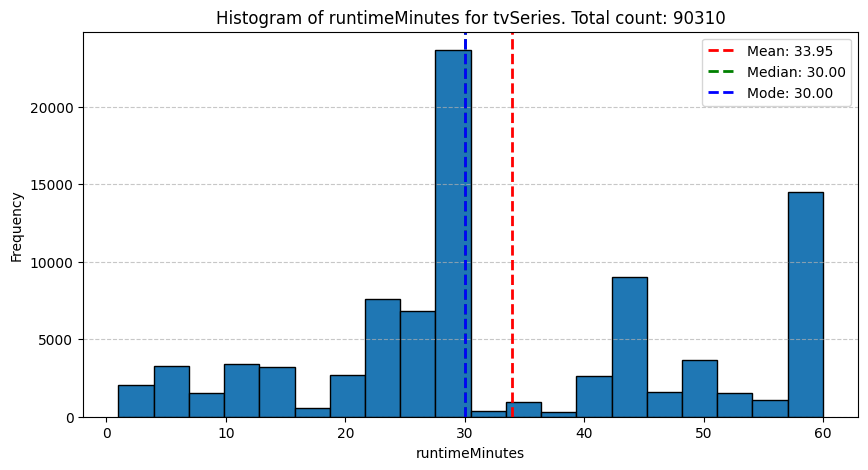

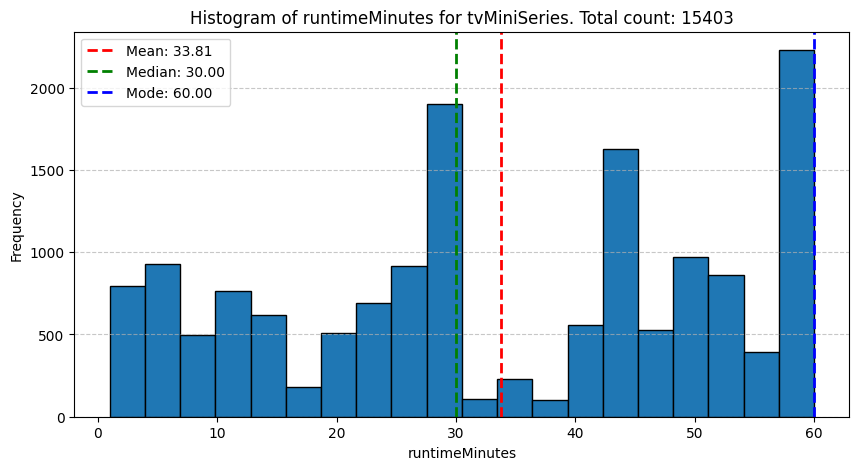

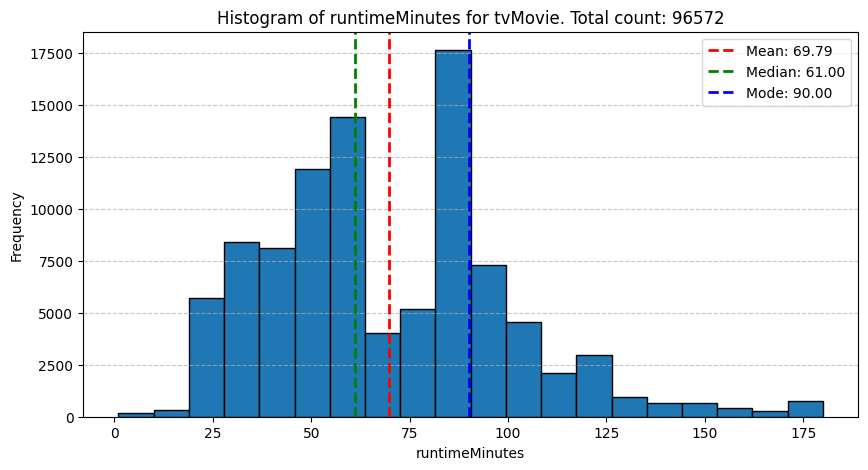

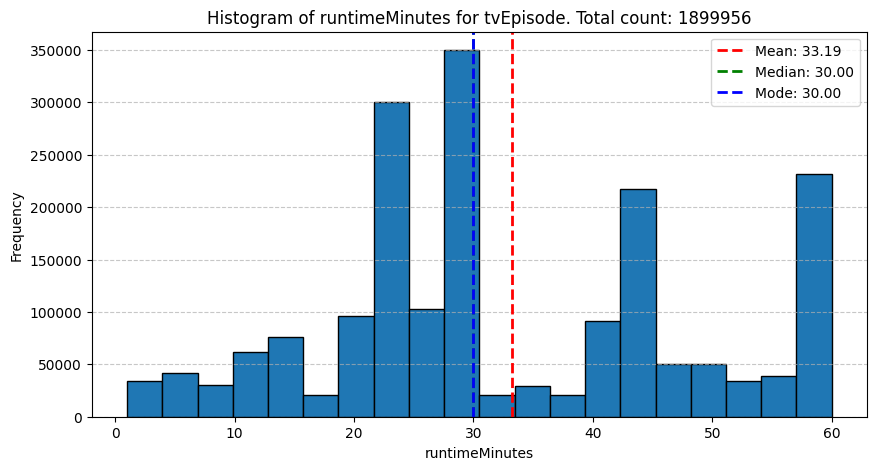

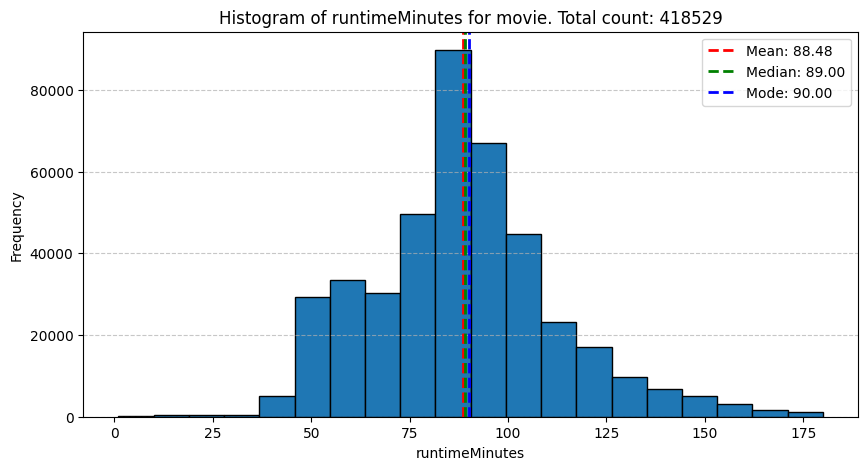

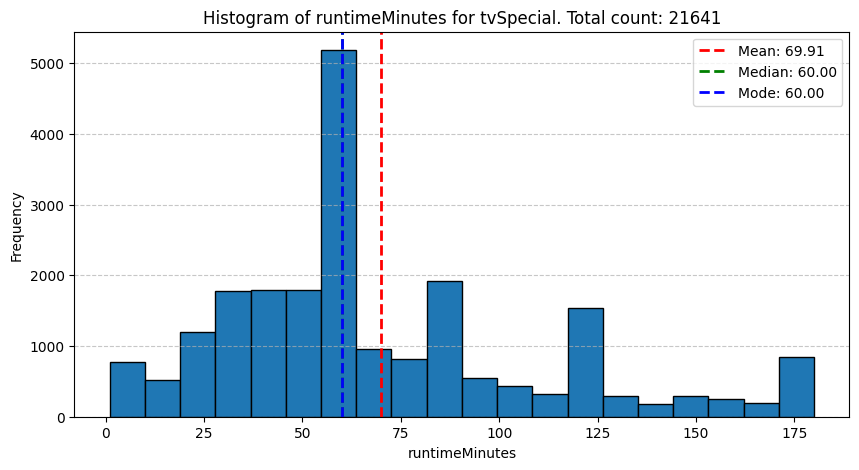

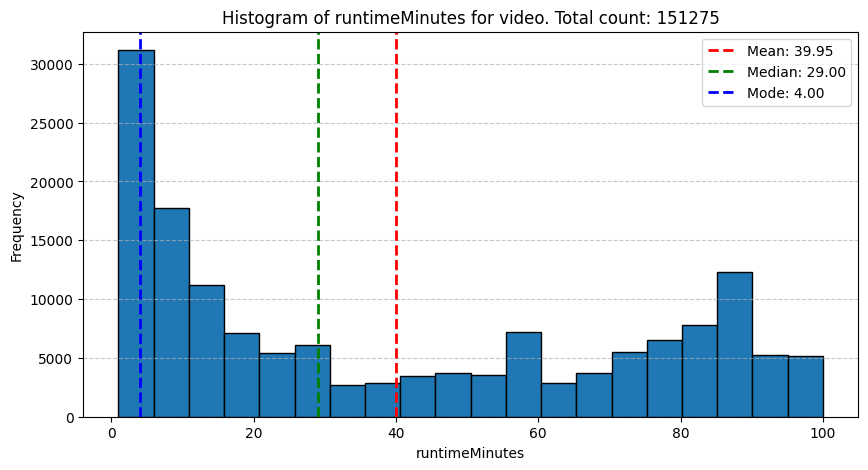

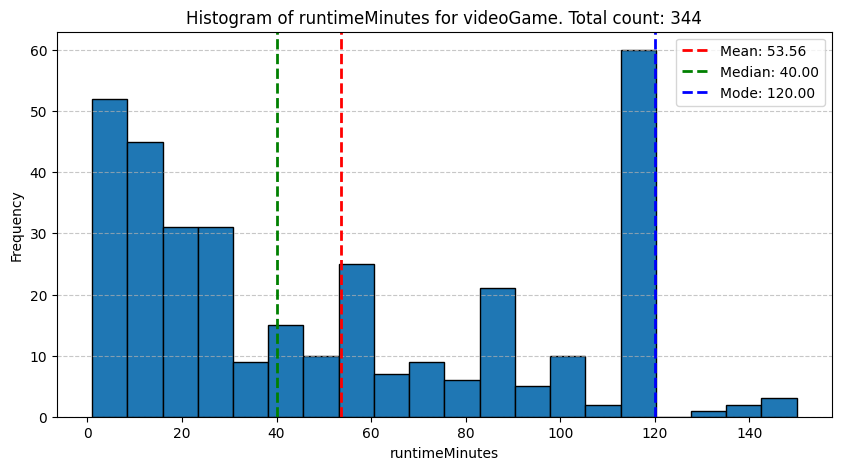

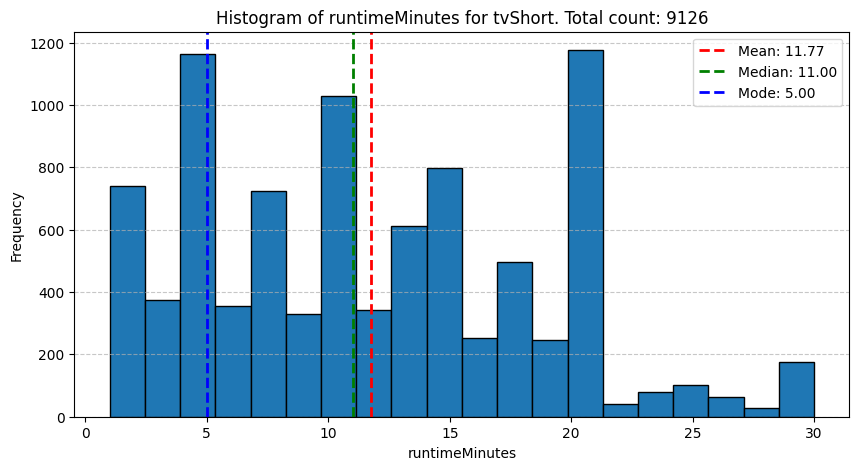

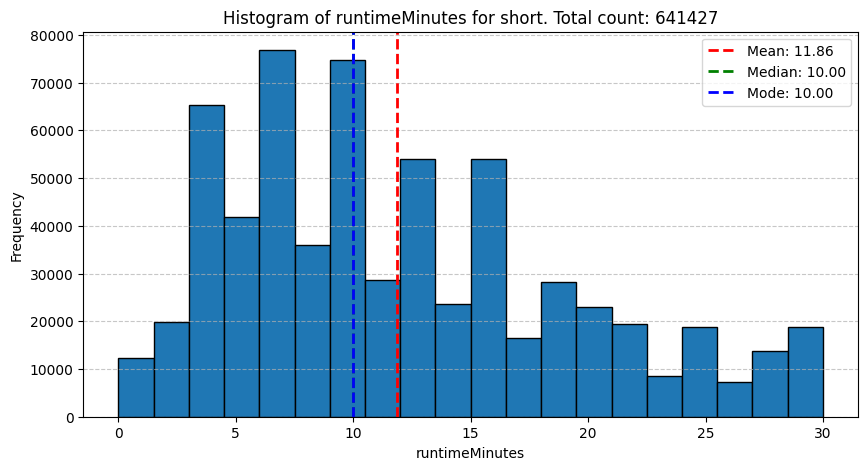

No valid data to plot titleType tvPilot.


In [23]:
title_types = ['tvSeries', 'tvMiniSeries', 'tvMovie',  'tvEpisode',
               'movie', 'tvSpecial', 'video', 'videoGame', 'tvShort',
               'short', 'tvPilot']

for title in title_types:
    df_new = df_runtime_suit.filter(F.col("titleType") == title)
    
    total_count = df_new.count()
    
    hist_data = df_new.select("runtimeMinutes").toPandas()
    
    if not hist_data.empty:
        mean_value = hist_data["runtimeMinutes"].mean()
        median_value = hist_data["runtimeMinutes"].median()
        mode_value = hist_data["runtimeMinutes"].mode().iloc[0]  # Take the first mode value if there are multiple
        
        plt.figure(figsize=(10, 5))
        plt.hist(hist_data["runtimeMinutes"], bins=20, edgecolor='black')  

        plt.xlabel("runtimeMinutes")
        plt.ylabel("Frequency")
        plt.title(f"Histogram of runtimeMinutes for {title}. Total count: {total_count}")

        plt.axvline(mean_value, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
        plt.axvline(median_value, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')
        plt.axvline(mode_value, color='b', linestyle='dashed', linewidth=2, label=f'Mode: {mode_value:.2f}')

        plt.legend()

        plt.grid(axis="y", linestyle="--", alpha=0.7)

        plt.show()
    else:
        print(f"No valid data to plot titleType {title}.")


In [21]:
df_new = count_nulls_percentage(df_runtime_suit, "runtimeMinutes")
df_new.show()

[Stage 76:==================================================>       (7 + 1) / 8]

+------------+-------------------+-----------+----------------------+
|   titleType|runtimeMinutes_null|total_count|runtimeMinutes_percent|
+------------+-------------------+-----------+----------------------+
|    tvSeries|                  0|      90310|                   0.0|
|tvMiniSeries|                  0|      15403|                   0.0|
|     tvMovie|                  0|      96572|                   0.0|
|   tvEpisode|                  0|    1899956|                   0.0|
|       movie|                  0|     418529|                   0.0|
|   tvSpecial|                  0|      21641|                   0.0|
|       video|                  0|     151275|                   0.0|
|   videoGame|                  0|        344|                   0.0|
|     tvShort|                  0|       9126|                   0.0|
|       short|                  0|     641427|                   0.0|
+------------+-------------------+-----------+----------------------+



## start and end year columns

In [22]:
min_max_years = df.select(
    F.min("startYear").alias("min_startYear"),
    F.max("startYear").alias("max_startYear"),
    F.min("endYear").alias("min_endYear"),
    F.max("endYear").alias("max_endYear")
)

min_max_years.show()


[Stage 33:==================================================>       (7 + 1) / 8]

+-------------+-------------+-----------+-----------+
|min_startYear|max_startYear|min_endYear|max_endYear|
+-------------+-------------+-----------+-----------+
|   1874-01-01|   2031-01-01| 1928-01-01| 2030-01-01|
+-------------+-------------+-----------+-----------+



In [13]:
df_new = count_nulls_percentage(df_filtered, "endYear")
df_new.show()

[Stage 4:===================================================>       (7 + 1) / 8]

+------------+------------+-----------+---------------+
|   titleType|endYear_null|total_count|endYear_percent|
+------------+------------+-----------+---------------+
|    tvSeries|      173591|     278607|          62.31|
|tvMiniSeries|       27884|      60474|          46.11|
|     tvMovie|      150250|     150250|          100.0|
|   tvEpisode|     8868567|    8868567|          100.0|
|       movie|      709649|     709649|          100.0|
|   tvSpecial|       51665|      51665|          100.0|
|       video|      307759|     307759|          100.0|
|   videoGame|       42319|      42319|          100.0|
|     tvShort|       10591|      10591|          100.0|
|       short|     1050227|    1050227|          100.0|
|     tvPilot|           1|          1|          100.0|
+------------+------------+-----------+---------------+



In [24]:
df_new = count_nulls_percentage(df, "startYear")
df_new.show()

[Stage 124:==========================================>              (6 + 2) / 8]

+------------+--------------+-----------+-----------------+
|   titleType|startYear_null|total_count|startYear_percent|
+------------+--------------+-----------+-----------------+
|    tvSeries|         22870|     278607|             8.21|
|tvMiniSeries|          4147|      60474|             6.86|
|     tvMovie|          4203|     150250|              2.8|
|   tvEpisode|       1246537|    8869402|            14.05|
|       movie|        104273|     709649|            14.69|
|   tvSpecial|           365|      51665|             0.71|
|       video|          1733|     307759|             0.56|
|   videoGame|          1126|      42319|             2.66|
|     tvShort|           100|      10591|             0.94|
|       short|         40116|    1050227|             3.82|
|     tvPilot|             0|          1|              0.0|
+------------+--------------+-----------+-----------------+



## Saving data

In [ ]:
output_path = "../data/title.basics.cleaned.tsv/title_basics.csv"
df_filtered.coalesce(1).write.option("header", True).option("sep", "\t").mode("overwrite").csv(output_path)

In [11]:

test = spark.read.csv(output_path, sep="\t", header=True, inferSchema=True)
test.show()

+---------+---------+--------------------+--------------------+-------+----------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult| startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+----------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|1894-01-01|   null|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|1892-01-01|   null|             5|     Animation,Short|
|tt0000003|    short|        Poor Pierrot|      Pauvre Pierrot|      0|1892-01-01|   null|             5|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|1892-01-01|   null|            12|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|1893-01-01|   null|             1|      

In [12]:
test.count()

11021894

In [13]:
counts = test.select([
    (
        F.count(F.when(F.isnan(c) | F.col(c).isNull(), 1))  
        if t in ("float", "double")  
        else F.count(F.when(F.col(c).isNull() | (F.col(c) == "\\N"), 1))
    ).alias(c)
    for c, t in df.dtypes
])

print("NaN Counts per Column:")
counts.show()

NaN Counts per Column:


[Stage 16:===========================================>              (6 + 2) / 8]

+------+---------+------------+-------------+-------+---------+--------+--------------+------+
|tconst|titleType|primaryTitle|originalTitle|isAdult|startYear| endYear|runtimeMinutes|genres|
+------+---------+------------+-------------+-------+---------+--------+--------------+------+
|     0|        0|           0|            0|      0|  1340823|10891645|       7432805|     0|
+------+---------+------------+-------------+-------+---------+--------+--------------+------+

